In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, 
                                     Dropout, 
                                     Activation, 
                                     Flatten, 
                                     Conv2D, 
                                     MaxPooling2D, 
                                     Reshape, 
                                     Lambda,
                                     Input
                                    )
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import *

In [4]:
loc_train = 'data\\train.csv'
loc_test = 'data\\test.csv'
target = 'label'

raw_train_data = pd.read_csv(loc_train)
y = raw_train_data[target]
raw_test_data = pd.read_csv(loc_test)
# raw_train_data.head(5)

In [5]:
def prepare(raw_DF):
    DF = raw_DF.copy()
    if target in DF.columns:
        DF = DF.drop(columns = [target], axis = 1)

    DF = DF.values.reshape(-1, 28, 28, 1)
    DF = DF/255  

#     DF = (DF-mean_px)/std_px
    return DF

In [6]:
X_train = prepare(raw_train_data)
X_test = prepare(raw_test_data)

mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

In [7]:
# y = to_categorical(y)
y.shape

(42000,)

In [8]:
X_train, Val_x, y, val_y = train_test_split(X_train, y, random_state = 249, test_size = 10000)

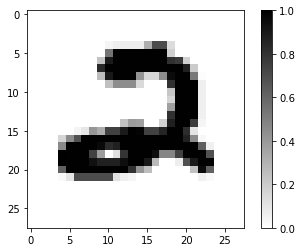

In [9]:
plt.imshow(X_test[0][:, :, 0], 
          cmap = plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [10]:
cleaner = [
    Input(shape=(784,)), 
    Lambda(lambda x: x/255.0), 
    Reshape((28, 28, 1))
]

CNN = [
    Conv2D(32, 
           (5, 5), 
           activation='relu' 
          ), 
    MaxPooling2D(pool_size=(2, 2))
]

In [11]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.07,
    height_shift_range=0.07,
    brightness_range=None, 
    shear_range=0.1,
    zoom_range=0.1,
    channel_shift_range=0.1,
    horizontal_flip=False, 
    vertical_flip=False,     
    
    validation_split = 0.25
)

In [12]:
# https://keras.io/api/callbacks/
callbacks = [
    ModelCheckpoint(
                    filepath='models', 
                    save_best_only=True,
                    save_weights_only=False
                   ), 
    EarlyStopping(patience = 4,
                  restore_best_weights=True,
                  monitor = 'val_loss'
    ),
#     TensorBoard(),    
]

In [13]:
model = Sequential()

# model.add(Lambda(standardize, input_shape=(28,28,1)))

model.add(BatchNormalization(axis=1))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.10))

model.add(BatchNormalization(axis=1))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dropout(0.10))

model.add(BatchNormalization(axis=1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.10))

model.add(BatchNormalization(axis=1))
model.add(Dense(10, activation='softmax'))

In [14]:
# model = Sequential([
#         Lambda(standardize, input_shape=(28,28,1)),
#         Conv2D(32,(3,3), activation='relu'),
#         BatchNormalization(axis=1),
#         Conv2D(32,(3,3), activation='relu'),
#         MaxPooling2D(),
#         BatchNormalization(axis=1),
#         Conv2D(64,(3,3), activation='relu'),
#         BatchNormalization(axis=1),
#         Conv2D(64,(3,3), activation='relu'),
#         MaxPooling2D(),
#         Flatten(),
#         BatchNormalization(),
#         Dense(512, activation='relu'),
#         BatchNormalization(),
#         Dense(10, activation='softmax')
#         ])

In [15]:
model.compile(
    optimizer='rmsprop',  
    loss='sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

In [16]:
history = model.fit(
    datagen.flow(X_train, y), 
    epochs = 32,
#     validation_split = 0.25,
    validation_data = (Val_x, val_y),
#     verbose = 2
    callbacks = callbacks
)

Train for 1000 steps, validate on 10000 samples
Epoch 1/32
 999/1000 [============================>.] - ETA: 0s - loss: 0.3083 - accuracy: 0.9057WARNING:tensorflow:From C:\Users\prasu\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models\assets
1000/1000 [==============================] - 525s 525ms/step - loss: 0.3083 - accuracy: 0.9057 - val_loss: 0.1068 - val_accuracy: 0.9714
Epoch 2/32
1000/1000 [==============================] - 524s 524ms/step - loss: 0.1276 - accuracy: 0.9625 - val_loss: 0.0564 - val_accuracy: 0.9863
Epoch 3/32
1000/1000 [==============================] - 513s 513ms/step - loss: 0.1033 - accuracy: 0.9709 - val_loss: 0.0749 -

In [17]:
ev = model.evaluate(Val_x, val_y)
ev

10000/10000 [==============================] - 29s 3ms/sample - loss: 0.0472 - accuracy: 0.9908


[0.047220742002183035, 0.9908]

In [18]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis = 1)

In [19]:
output = pd.DataFrame({'ImageId': range(1, len(X_test)+1), 'Label': predictions})
output.to_csv('preds\\bn_c9c5pc5c3_512_10_e-es16.csv', index = False)
# output.to_csv('bnn_sparse.csv', index = False)

In [20]:
sm = keras.models.load_model('models')

In [21]:
model = sm

In [22]:
p = np.argmax(sm.predict(Val_x), axis = 1)

In [23]:
sum(p==val_y)

9908

In [24]:
sm.evaluate(Val_x, val_y)

10000/10000 [==============================] - 29s 3ms/sample - loss: 0.0456 - accuracy: 0.9908


[0.04561601200666264, 0.9908]